<a href="https://colab.research.google.com/github/therishabhmittal-05/music/blob/main/NonSpeech7k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# ! unzip /content/drive/MyDrive/6967442.zip

In [35]:
# !unzip /content/train.zip

In [3]:
import pandas as pd
import numpy as np
import torch
import librosa
import cv2
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
ds = pd.read_csv("/content/metadata of train set .csv")
ds.head()

,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/


In [6]:
class_ind = {
    'breath' : 0,
    'cough' : 1,
    'crying' : 2,
    'laugh' : 3,
    'screaming' : 4,
    'sneeze' : 5,
    'yawn' : 6
}
def class_index(ds):
  ds['label'] = ds.Classname.map(class_ind)

class_index(ds)
n_labels = len(class_ind)

In [7]:
ds.head()

,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source,label
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/,0
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/,0
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/,0
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/,0
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/,0


In [8]:
class config:
  in_dir = "/content/train/"
  out_dir = "/content/mel_spectrograms/"
  sr = 32000
  n_fft = 1024
  hop_length = 256
  n_mels = 128
  fmin = 20
  fmax = 16000
  t_shape = (256, 256)

In [9]:
# import IPython.display as ip
# audio = config.in_dir + ds.Filename[0]
# label = ds.Classname[0]
# print(label)
# print(audio)
# ip.Audio(audio)

In [10]:
# y, sr = librosa.load(audio)

# mel = librosa.feature.melspectrogram(
#     y=y,
#     sr = config.sr,
#     n_fft = config.n_fft,
#     hop_length = config.hop_length,
#     n_mels = config.n_mels,
#     fmin = config.fmin,
#     fmax = config.fmax
# )
# mel = librosa.power_to_db(mel, ref = np.max)
# librosa.display.specshow(mel)
# print(label)
# print(mel.shape)

In [11]:
# mel = get_mel(audio)
# librosa.display.specshow(mel)

In [12]:
def get_mel(y):
  mel = librosa.feature.melspectrogram(
      y=y,
      sr = config.sr,
      n_fft = config.n_fft,
      hop_length = config.hop_length,
      n_mels = config.n_mels,
      fmin = config.fmin,
      fmax = config.fmax
  )
  mel = librosa.power_to_db(mel, ref = np.max)
  mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
  return mel

In [14]:
for i, row in tqdm(ds.iterrows(), total=len(ds)):
  audio = config.in_dir + row.Filename
  y, _ = librosa.load(audio)
  mel = get_mel(y)
  if mel.shape != config.t_shape:
    mel = cv2.resize(mel, config.t_shape, interpolation = cv2.INTER_LINEAR)
  out_path = f"{config.out_dir}{row.Classname}_{row.label}_{i}.npy"
  np.save(out_path, mel.astype(np.float32))

100%|██████████| 6289/6289 [02:04<00:00, 50.71it/s]


[[0.5190806  0.6117401  0.61100936 ... 0.55907565 0.5970952  0.64601773]
 [0.5106323  0.6023493  0.6009021  ... 0.5598372  0.59106    0.6376522 ]
 [0.4937356  0.5835675  0.5806875  ... 0.56136036 0.57898957 0.62092113]
 ...
 [0.33339486 0.36320707 0.36959282 ... 0.35879532 0.35991248 0.36585495]
 [0.29144675 0.3354162  0.3343425  ... 0.2977531  0.31352156 0.31491715]
 [0.27047268 0.32152075 0.31671736 ... 0.26723197 0.29032612 0.28944823]]
breath


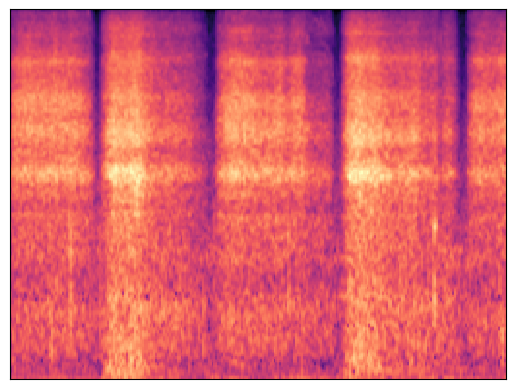

In [15]:
test = config.out_dir + os.listdir(config.out_dir)[1]
mel = np.load(test)
print(mel)
print(os.path.basename(test).split('_')[0])
librosa.display.specshow(mel)

In [16]:
# len(os.listdir("/content/mel_spectrograms"))
# files= [f for f in os.listdir("/content/mel_spectrograms") if f.endswith('.npy')]

In [17]:
# files[0].split('_')[1]
# filepath = os.path.join("/content/mel_spectrograms/", files[0])
# print(filepath)

In [18]:
class NonSpeech(Dataset):
  def __init__(self, mel_dir):
    self.mel_dir = mel_dir # /content/mel_spectrograms/
    self.files = [f for f in os.listdir(self.mel_dir) if f.endswith('.npy')]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    filename = self.files[idx]
    filepath = os.path.join(self.mel_dir, filename)
    img = np.load(filepath)
    img = torch.from_numpy(img).float()
    img = img.repeat(3, 1, 1)

    label = torch.tensor(int(filename.split('_')[1]), dtype = torch.long)

    return img, label

In [19]:
NonSpeechDs = NonSpeech(config.out_dir)

In [20]:
train_size = int(0.8 * len(NonSpeechDs))
val_size = len(NonSpeechDs) - train_size
NonSpeech_train, NonSpeech_val = random_split(NonSpeechDs, [train_size, val_size])

In [21]:
batch_size=8
train_load = DataLoader(NonSpeech_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_load = DataLoader(NonSpeech_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [22]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import torch.nn as nn

In [23]:
class NonSpeechModel(nn.Module):
  def __init__(self, n_labels):
    super().__init__()
    base = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
    self.features = base.features
    self.avg_pool = base.avgpool
    self.classifier = nn.Linear(base.classifier[1].in_features, n_labels)
  def forward(self, x):
    x = self.features(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)

In [24]:
model = NonSpeechModel(n_labels).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 169MB/s]


In [25]:
# from torchsummary import summary
# summary(model, (3, 256, 256))

In [26]:
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [27]:
from torch.cuda.amp import autocast, GradScaler
def train(model, train_load, optimizer, scheduler, criterion, n_epochs=50):
  losses = []
  accuracies = []
  scaler = GradScaler()
  for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for sample, label in tqdm(train_load, total=len(train_load)):
      sample = sample.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      with autocast():
        yhat = model(sample)
        loss = criterion(yhat, label)

      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # loss.backward()
      # optimizer.step()

      running_loss += loss.item() * sample.size(0)

      preds = torch.argmax(yhat, dim=1)
      correct += (preds == label).sum().item()
      total += label.size(0)

    epoch_loss = running_loss / len(train_load.dataset)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    scheduler.step(losses[-1])
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
  return losses, accuracies

In [28]:
losses, accuracies = train(model, train_load, optimizer, scheduler, criterion, n_epochs=10)
losses, accuracies

<ipython-input-27-efc381bdb7c6>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/629 [00:00<?, ?it/s]<ipython-input-27-efc381bdb7c6>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 629/629 [01:52<00:00,  5.58it/s]


Epoch 1/10 - Loss: 0.7232, Accuracy: 0.7517


100%|██████████| 629/629 [01:50<00:00,  5.67it/s]


Epoch 2/10 - Loss: 0.3394, Accuracy: 0.8883


100%|██████████| 629/629 [01:50<00:00,  5.67it/s]


Epoch 3/10 - Loss: 0.2081, Accuracy: 0.9310


100%|██████████| 629/629 [01:49<00:00,  5.72it/s]


Epoch 4/10 - Loss: 0.1200, Accuracy: 0.9616


100%|██████████| 629/629 [01:51<00:00,  5.66it/s]


Epoch 5/10 - Loss: 0.1085, Accuracy: 0.9652


100%|██████████| 629/629 [01:50<00:00,  5.69it/s]


Epoch 6/10 - Loss: 0.0796, Accuracy: 0.9756


100%|██████████| 629/629 [01:52<00:00,  5.60it/s]


Epoch 7/10 - Loss: 0.0715, Accuracy: 0.9775


100%|██████████| 629/629 [01:49<00:00,  5.72it/s]


Epoch 8/10 - Loss: 0.0732, Accuracy: 0.9759


100%|██████████| 629/629 [01:51<00:00,  5.64it/s]


Epoch 9/10 - Loss: 0.0680, Accuracy: 0.9795


100%|██████████| 629/629 [01:50<00:00,  5.71it/s]

Epoch 10/10 - Loss: 0.0587, Accuracy: 0.9815


([0.7231720658117297,
  0.339369181727965,
  0.20813466135032596,
  0.12004665652176325,
  0.1084851712237246,
  0.079570748962653,
  0.07153010448687855,
  0.07322692221847513,
  0.06801324456103058,
  0.05874912486722812],
 [0.7517392168554959,
  0.8882925859670046,
  0.9310276287020474,
  0.9616378453587756,
  0.9652156628900815,
  0.975551580202743,
  0.9775392566090241,
  0.9759491154839992,
  0.9795269330153051,
  0.9815146094215862])

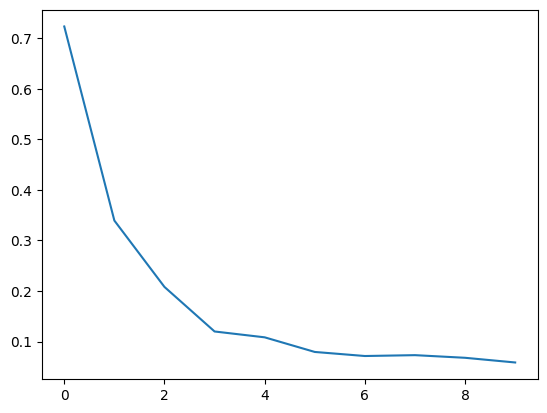

In [29]:
plt.plot(losses)
plt.show()

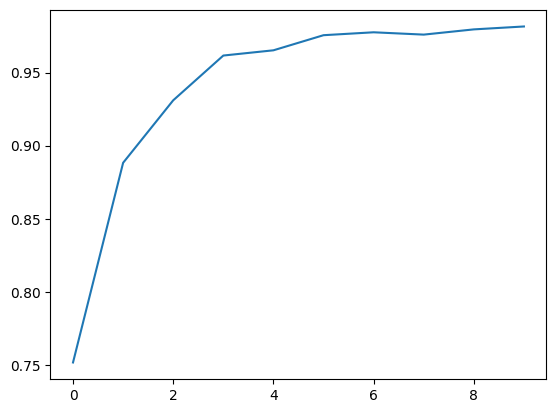

In [30]:
plt.plot(accuracies)
plt.show()

total 2480556
drwxr-xr-x 1 root root       4096 May 13 12:05  ./
drwxr-xr-x 1 root root       4096 May 13 11:59  ../
drwxr-xr-x 4 root root       4096 May  9 13:41  .config/
drwx------ 6 root root       4096 May 13 12:04  drive/
drwxr-xr-x 2 root root       4096 May 13 12:05  .ipynb_checkpoints/
drwxr-xr-x 2 root root     253952 May 13 12:10  mel_spectrograms/
-rw------- 1 root root      51845 May 12 10:25 'metadata of test set.csv'
-rw------- 1 root root     478461 May 12 10:25 'metadata of train set .csv'
drwxr-xr-x 1 root root       4096 May  9 13:41  sample_data/
-rw------- 1 root root  221775350 May 12 10:23  test.zip
drwxr-xr-x 2 root root     274432 May 13 12:06  train/
-rw------- 1 root root 2317217784 May 12 10:08  train.zip
-rw------- 1 root root       1363 May 12 10:23 'youtube ID vs link .TXT'


In [31]:
!du -sh mel_spectrograms/

1.6G	mel_spectrograms/


In [32]:
def evaluate(model, val_load, criterion):
  model.eval()
  running_loss = 0.0
  correct, total = 0, 0
  with torch.no_grad():
    for sample, label in tqdm(val_load, total = len(val_load)):
      sample = sample.to(device)
      label = label.to(device)

      with autocast():
        yhat = model(sample)
        loss = criterion(yhat, label)

      running_loss += loss.item() * sample.size(0)
      preds = torch.argmax(yhat, dim=1)
      correct += (preds == label).sum().item()
      total += label.size(0)
    val_loss = running_loss / len(val_load.dataset)
    val_acc = correct / total
  return val_loss, val_acc

loss, accuracy = evaluate(model, val_load, criterion)

  0%|          | 0/158 [00:00<?, ?it/s]<ipython-input-32-2f016de9c055>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 158/158 [00:09<00:00, 16.67it/s]


In [33]:
print(loss, accuracy)

0.3504360865902256 0.9038155802861685


In [34]:
torch.save(model.state_dict(), "model01.pth")